In [1]:
import pandas as pd
import numpy as np
import sqlite3
import altair as alt
import scipy.interpolate as interpolate
from scipy.stats import skewnorm, beta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
con = sqlite3.connect("switrs.sqlite")

query = """
    SELECT * FROM collisions WHERE county_location = 'los angeles'
    """

df = pd.read_sql_query(query, con, parse_dates = ["collision_date"])
df["year"] = df["collision_date"].dt.year
df["hour"] = pd.to_datetime(df["collision_time"], format = "%H:%M:%S").dt.hour
df = df.query("year < 2021") # remove incomplete 2021 data
df["alcohol_involved"] = df["alcohol_involved"].fillna(0) # convert NaN to 0 in alcohol use column

dfc = df[["case_id", "county_location", "alcohol_involved", "collision_severity", "injured_victims", "collision_date", "year", "collision_time", "hour", "party_count", "hit_and_run", "distance"]]

In [3]:
# build data frame
dftod = pd.DataFrame()
dftod["hour"] = range(0, 24)
dftod["p"] = dfc.groupby("hour")["alcohol_involved"].mean()
dftod["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# fit and scale skewnormal
shape, loc, scale = skewnorm.fit(dftod["p"])
dftod["p_fit"] = skewnorm.pdf(dftod["p"], shape, loc, scale)
dftod["p_fit_scale"] = -dftod["p_fit"] / max(dftod["p_fit"]) * max(dftod["p"]) + abs(max(dftod["p"]) + min(dftod["p"])) # scale

# plot fit against test data
palc_base = alt.Chart(dftod).mark_bar(width = 20).encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

palc_fit = alt.Chart(dftod).mark_line(color = "red").encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p_fit", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

palc_fit_scale = alt.Chart(dftod).mark_line(color = "red").encode(
    x = alt.X("adj_hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p_fit_scale", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

(palc_base + palc_fit).display()
(palc_base + palc_fit_scale).display()

alt.LayerChart(...)

alt.LayerChart(...)

In [35]:
# FIXING SKEWNORMAL HERE

# build data frame
dftod = pd.DataFrame()
dftod["hour"] = range(0, 24)
dftod["p"] = dfc.groupby("hour")["alcohol_involved"].mean()
dftod["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# fit and scale skewnormal
mean, var, skew, kurt = beta.fit(dftod["p"])



dftod["p_fit"] = beta.pdf(dftod["p"], mean, var, skew, kurt)








# plot fit against test data
palc_base = alt.Chart(dftod).mark_bar(width = 20).encode(
    x = alt.X("hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

palc_fit = alt.Chart(dftod).mark_line(color = "red").encode(
    x = alt.X("hour", title = "Hour of day", scale = alt.Scale(domain = [-0.5, 23.5]),
               axis = alt.Axis(labelExpr = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]")),
    y = alt.Y("p_fit", title = "Proportion of accidents with alcohol involved")
).properties(width = 600, height = 200)

(palc_base + palc_fit).display()

alt.LayerChart(...)

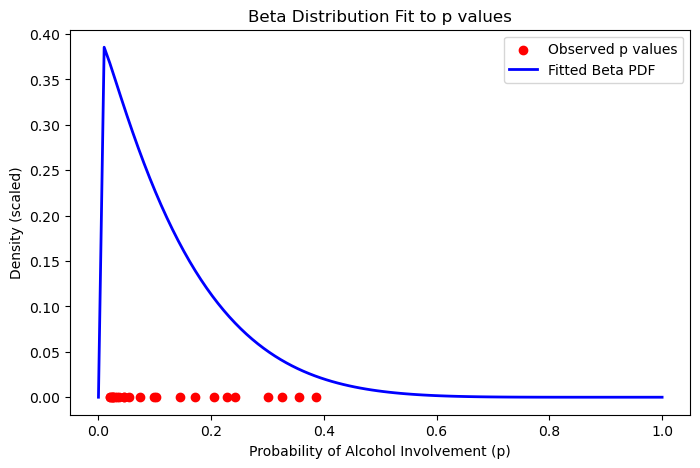

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

# Build data frame
dftod = pd.DataFrame()
dftod["hour"] = range(0, 24)
dftod["p"] = dfc.groupby("hour")["alcohol_involved"].mean()

# Fit Beta distribution to probability values
a, b, loc, scale = beta.fit(dftod["p"], floc=0, fscale=1)  # Force bounds [0,1]

# Generate PDF over the range of p values
x_vals = np.linspace(0, 1, 100)  # Generate 100 points from 0 to 1
pdf_vals = beta.pdf(x_vals, a, b, loc, scale)  # Compute PDF

# Normalize the PDF to match probability scale for visualization
pdf_vals = pdf_vals / pdf_vals.max() * dftod["p"].max()

# Plot the results
plt.figure(figsize=(8, 5))
plt.scatter(dftod["p"], np.zeros_like(dftod["p"]), color="red", label="Observed p values", zorder=2)
plt.plot(x_vals, pdf_vals, label="Fitted Beta PDF", color="blue", linewidth=2, zorder=1)
plt.xlabel("Probability of Alcohol Involvement (p)")
plt.ylabel("Density (scaled)")
plt.legend()
plt.title("Beta Distribution Fit to p values")
plt.show()

In [66]:
x = dfc.groupby("hour")["hour"].mean()
ya = dfc[dfc["alcohol_involved"] == 1].groupby("hour")["alcohol_involved"].count() / len(dfc[dfc["alcohol_involved"] == 1])
yn = dfc[dfc["alcohol_involved"] == 0].groupby("hour")["alcohol_involved"].count() / len(dfc[dfc["alcohol_involved"] == 0])
adj_hour = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
adjlabel = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]"

dfah = pd.DataFrame({"hour": x, "adj_hour": adj_hour, "collisions_a": ya, "collisions_n": yn})

pla = alt.Chart(dfah).mark_bar(width = 20, color = "orange", opacity = 0.75).encode(
    x = alt.X("adj_hour:O", title = "Hour of the day", axis = alt.Axis(labelExpr = adjlabel)),
    y = alt.Y("collisions_a", title = "Number of collisions (alcohol involved)").stack(None)
).properties(width = 600, height = 200)

pln = alt.Chart(dfah).mark_bar(width = 20, opacity = 0.75).encode(
    x = alt.X("adj_hour:O", title = "Hour of the day", axis = alt.Axis(labelExpr = adjlabel)),
    y = alt.Y("collisions_n", title = "Number of collisions (alcohol not involved)").stack(None)
).properties(width = 600, height = 200)

(pln + pla).resolve_axis(y = "independent").display()

alt.LayerChart(...)

In [75]:
x = dfc.groupby("hour")["hour"].mean()
y = dfc.groupby("hour")["alcohol_involved"].mean()
xx = np.linspace(x.min(), x.max(), 24)

t, c, k = interpolate.splrep(x, y, k = 3, s = 0.0001)
ypred = interpolate.splev(xx, (t, c, k))

adj_hour = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
dfspl = pd.DataFrame({"hour": x, "adj_hour": adj_hour, "p": y, "p_fit": ypred})

spl_rmse = mean_squared_error(dfspl["p"], dfspl["p_fit"])
print("Root mean squared error: %.5f" % (np.sqrt(spl_rmse)))

adjlabel = "{0: '8am', 1: '9am', 2: '10am', 3: '11am', 4: '12pm', 5: '1pm', 6: '2pm', 7: '3pm', 8: '4pm', 9: '5pm', 10: '6pm', 11: '7pm', 12: '8pm', 13: '9pm', 14: '10pm', 15: '11pm', 16: '12am', 17: '1am', 18: '2am', 19: '3am', 20: '4am', 21: '5am', 22: '6am', 23: '7am'}[datum.value]"
adjscale = alt.Scale(domain = [-0.5, 23.5])

spl_base = alt.Chart(dfspl).mark_bar(width = 20).encode(
    x = alt.X("hour"),
    y = alt.Y("p")
).properties(width = 600, height = 200)

spl = alt.Chart(dfspl).mark_line(color = "red").encode(
    x = alt.X("hour"),
    y = alt.Y("p_fit")
).properties(width = 600, height = 200)

(spl_base + spl).display()

spl_base = alt.Chart(dfspl).mark_bar(width = 20, color = "orange").encode(
    x = alt.X("adj_hour", axis = alt.Axis(labelExpr = adjlabel)),
    y = alt.Y("p")
).properties(width = 600, height = 200)

spl = alt.Chart(dfspl).mark_line(color = "red").encode(
    x = alt.X("adj_hour", title = "Hour of the day", scale = adjscale),
    y = alt.Y("p_fit", title = "Probability of alcohol involvement")
).properties(width = 600, height = 200)

(spl_base + spl).display()

Root mean squared error: 0.00204


alt.LayerChart(...)

alt.LayerChart(...)

In [22]:
p = dfc.groupby("hour")["alcohol_involved"].mean()
hour = dfc.groupby("hour")["hour"].mean()

sinhour = np.sin(2 * np.pi * hour / 24)
coshour = np.cos(2 * np.pi * hour / 24)

dfcyc = pd.DataFrame({"hour": hour, "sinhour": sinhour, "coshour": coshour, "p": p})

alt.Chart(dfcyc).mark_circle(size = 500).encode(
    x = "sinhour",
    y = "coshour",
    color = alt.Color("p", scale = alt.Scale(scheme = "cividis"))
).display()

bs = sm.gam.BSplines(
    dfcyc[["sinhour", "coshour"]],
    df = [4, 4],
    degree = [3, 3]
)

import statsmodels.sandbox.distributions.extras as sme

gam_bs = sm.gam.GLMGam(p, dfcyc[["sinhour", "coshour"]], smoother = bs, family = sm.families.Binomial())
res_bs = gam_bs.fit()   
res_bs.summary()

dfcyc["preds"] = res_bs.predict()
dfcyc["adj_hour"] = [16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

cyc_base = alt.Chart(dfcyc).mark_bar(width = 20).encode(
    x = "adj_hour",
    y = "p"
).properties(width = 600, height = 300)

cyc_fit = alt.Chart(dfcyc).mark_line(color = "red").encode(
    x = "adj_hour",
    y = "preds"
).properties(width = 600, height = 300)

(cyc_base + cyc_fit).display()

alt.Chart(...)

alt.LayerChart(...)

In [ ]:
dfrf = df.copy()

dfrf["minute"] = pd.to_datetime(df["collision_time"], format = "%H:%M:%S").dt.minute
dfrf["day"] = pd.to_datetime(df["collision_time"], format = "%H:%M:%S").dt.day_of_year


drop_feats = ["collision_severity", "killed_victims", "injured_victims", "severe_injury_count",
              "other_visible_injury_count", "complaint_of_pain_injury_count", "pedestrian_killed_count", "pedestrian_injured_count",
              "bicyclist_killed_count", "bicyclist_injured_count", "motorcyclist_killed_count", "motorcyclist_injured_count",
              "case_id", "process_date", "hour", "collision_date", "process_date", "collision_time",
              "city_division_lapd", "caltrans_county", "caltrans_district", "state_route", "postmile"]

dfnan = pd.DataFrame()
dfnan["predictor"] = (dfrf.isna().sum() / dfrf.isna().count()).sort_values().index
dfnan["p_nan"] = (dfrf.isna().sum() / dfrf.isna().count()).sort_values().values

drop_nans = dfnan.query("p_nan > 0.8")["predictor"] # drop features that are more than 80 % nan

X = dfrf.drop(drop_feats, axis = 1).drop(drop_nans, axis = 1).convert_dtypes()

numcols = []
for column in X:
    if X[column].dtype != "string[python]":
        numcols.append(column)
badnumcols = [column for column in numcols if column not in ["distance", "party_count", "latitude", "longitude", "year", "minute", "day"]] # only keep these ones as numeric
X[badnumcols] = X[badnumcols].astype("string[python]")

badcats = [column for column in X if X[column].nunique() > 100 and X[column].dtype == "string[python]"]
X = X.drop(badcats, axis = 1) # drop categorical features with more than 100 unique groups


In [ ]:
alt.Chart(dfnan.sort_values("p_nan")).mark_bar().encode(
    x = alt.X("predictor", sort = "y", title = "Feature").axis(labelAngle = 50, labelFontSize = 12),
    y = alt.Y("p_nan", title = "Percent missing rows")
).properties(width = 1000, height = 200)

In [ ]:
# finding number of unique groups for categorical features

strcolumns = []
for column in X:
    if X[column].dtype == "string[python]":
        strcolumns.append(column)

columns, uniques = [], []

for column in strcolumns:
    columns.append(column)
    uniques.append(len(X[column].value_counts()))
                   
opdf = pd.DataFrame({"column": columns, "unique": uniques})

badcats = opdf.query("unique > 100")["column"].values
uns = opdf.sort_values("unique", ascending = False)

In [ ]:
alt.Chart(uns).mark_bar().encode(
    x = alt.X("column", sort = "y"),
    y = alt.Y("unique")
)

In [ ]:
Xoh = pd.get_dummies(X)
y = dfrf["injured_victims"].fillna(0)

X_tr, X_te, y_tr, y_te = train_test_split(Xoh, y, random_state = 13)

rf = RandomForestRegressor(n_estimators = 10, random_state = 13)

rff = rf.fit(X_tr, y_tr)

In [ ]:
# pd.DataFrame(df.columns.values.reshape(15, 5))

varlist = list(X.columns) + [" ", " "]
pd.DataFrame(np.reshape(varlist, (9, 5)))

In [ ]:
rfpred = rff.predict(X_te)

print("RMSE: %.3f" % (np.sqrt(mean_squared_error(y_te, rfpred))))
print("Proportion correct: %.3f "% ((y_te == rfpred.astype(int)).mean()))

In [ ]:
import matplotlib.pyplot as plt

cf = confusion_matrix(y_te, rfpred.astype(int))

cmp = ConfusionMatrixDisplay(confusion_matrix=cf)

fig, ax = plt.subplots(figsize=(18,18))
cmp.plot(ax=ax)

In [ ]:
pd.DataFrame({"feature": rff.feature_names_in_, "importance": rff.feature_importances_}).sort_values("importance", ascending = False).head(20)

In [ ]:
Xoh2 = pd.get_dummies(X.drop("party_count", axis = 1))
y2 = dfrf["injured_victims"].fillna(0) / dfrf["party_count"].fillna(1) # repeating this time using the injuries per party involved

X2_tr, X2_te, y2_tr, y2_te = train_test_split(Xoh2, y2, random_state = 13)

rf2 = RandomForestRegressor(n_estimators = 10, random_state = 13)

rff2 = rf2.fit(X2_tr, y2_tr)

In [ ]:
rfpred2 = rff2.predict(X2_te)

print("RMSE: %.3f" % (np.sqrt(mean_squared_error(y2_te, rfpred2))))
print("Proportion correct: %.3f "% ((y2_te == rfpred2.astype(int)).mean()))

pd.DataFrame({"feature": rff2.feature_names_in_, "importance": rff2.feature_importances_}).sort_values("importance", ascending = False).head(20)

In [ ]:
Xoh3 = pd.get_dummies(X)
y3 = dfrf["collision_severity"] # repeating this time using categorical label

X3_tr, X3_te, y3_tr, y3_te = train_test_split(Xoh3, y3, random_state = 13)

rf3 = RandomForestClassifier(n_estimators = 10, random_state = 13)

rff3 = rf3.fit(X3_tr, y3_tr)

In [ ]:
rfpred3 = rff3.predict(X3_te)

print("Proportion correct: %.3f "% ((y3_te == rfpred3).mean()))

cf3 = confusion_matrix(y3_te, rfpred3)

cmp3 = ConfusionMatrixDisplay(confusion_matrix=cf3, display_labels=True)

fig, ax = plt.subplots(figsize=(10,10))
cmp3.plot(ax=ax)

pd.DataFrame({"feature": rff3.feature_names_in_, "importance": rff3.feature_importances_}).sort_values("importance", ascending = False).head(20)

0: fatal, 1: other injury, 2: pain, 3: property damage only, 4: severe injury

In [ ]:
print(y3_te.value_counts())

for row in cf3:
    print(row.sum())

In [ ]:
meanidf = dfc[["hour", "injured_victims"]].groupby("hour").mean().reset_index()
sumidf = dfc[["hour", "injured_victims"]].groupby("hour").sum().reset_index()

imean = alt.Chart(meanidf).mark_bar(width = 30, color = "darkred").encode(
    x = alt.X("hour:O"),
    y = alt.Y("injured_victims", title = "mean injured victims per collision").stack(None)
).properties(width = 800, height = 140)

isum = alt.Chart(sumidf).mark_bar(width = 30, color = "darkred").encode(
    x = alt.X("hour:O"),
    y = alt.Y("injured_victims", title = "total injured victims per hour").stack(None)
).properties(width = 800, height = 140)

(imean & isum).display()

In [ ]:
dfhr = dfc[["injured_victims", "hit_and_run"]]

alt.Chart(dfhr).mark_line().encode(
    x = alt.X("injured_victims", title = "Number of injured victims"),
    y = alt.Y("count()").stack(None).scale(type = "log"),
    color = "hit_and_run"
).properties(width = 800)

In [ ]:
dfhr

dfhr.query("hit_and_run == 'not hit and run'").groupby("injured_victims").mean()

In [ ]:
dfdis = dfc[["injured_victims", "distance"]]

In [ ]:
alt.Chart(dfdis).mark_circle().encode(
    x = alt.X("distance"),
    y = alt.Y("injured_victims")
)